In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor

import pickle
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import LinearSVR, SVR

from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error 

In [3]:
%matplotlib inline
np.random.seed(24680)
warnings.filterwarnings("ignore")

# Training a prediction model for the average rating of a book
---
### Motivation
This project will serve as an item based recommendation system for the average rating of a book. Thus no new user preferences will be taken into account. We will solely rely on the already rated books.

### Data source
The dataset is a sample from Goodreads.com and is published at: https://www.kaggle.com/jealousleopard/goodreadsbooks

In [4]:
books_data = pd.read_csv("/content/drive/MyDrive/College/8th Sem CSE Notes/8 Sem Notes/ML/Lab/datasets/books.csv",
                         error_bad_lines=False,
                         warn_bad_lines=False)

### Columns description: 
- **bookID** unique Identification number for each book.
- **title** The name under which the book was published.
- **authorsNames** of the authors of the book. Multiple authors are delimited with -.
- **average_rating** The average rating of the book received in total.
- **isbn** Another unique number to identify the book, the International Standard Book Number.
- **isbn13** A 13-digit ISBN to identify the book, instead of the standard 11-digit ISBN.
- **language_code** Helps understand what is the primary language of the book. For instance, eng is standard for English.
- **\# num_pages** Number of pages the book contains.
- **ratings_count** Total number of ratings the book received.
- **text_reviews_count** Total number of written text reviews the book received.

In [5]:
books_data.sample(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,# num_pages,ratings_count,text_reviews_count
11211,37476,Why I Hate Canadians,Will Ferguson,3.71,1550546007,9781550546002,en-GB,220,608,47
12959,44739,Graphic Design Solutions,Robin Landa,4.03,1401881548,9781401881542,en-US,403,138,11
7068,22188,Gossip Girl (Gossip Girl #1),Cecily von Ziegesar,3.51,0316910333,9780316910330,eng,224,53230,2245
5061,15138,La mujer del viajero en el tiempo,Audrey Niffenegger-Silvia Alemany,3.96,0307344835,9780307344830,spa,608,19,2
8853,28466,ADHD in Adulthood: A Guide to Current Theory ...,Margaret Weiss-Gabrielle Weiss-Lily Trokenberg...,3.40,080186822X,9780801868221,eng,376,5,0


In [6]:
books_data.shape

(13714, 10)

In [7]:
books_data.dtypes

bookID                  int64
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                  int64
language_code          object
# num_pages             int64
ratings_count           int64
text_reviews_count      int64
dtype: object

In [8]:
books_data.isna().any().any()

False

There are no NA values in the dataset.

In [9]:
books_data.rename(columns={"# num_pages":"pages_count"}, inplace=True)

In [10]:
books_data.sample(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,pages_count,ratings_count,text_reviews_count
2643,7967,Speaker for the Dead (Ender's Saga #2),Orson Scott Card,4.06,0812550757,9780812550757,eng,382,182235,6426
12966,44766,Purple Cane Road (Dave Robicheaux #11),James Lee Burke,4.15,0440224047,9780440224044,en-US,387,5304,237
1636,4909,Teacher Man (Frank McCourt #3),Frank McCourt,3.75,0743243781,9780743243780,eng,272,25726,1991
13133,45438,Legend of the Worst Boy in the World,Eoin Colfer-Glenn McCoy,3.74,0786855037,9780786855032,en-US,101,321,44
13077,45251,Judas Unchained (Commonwealth Saga #2),Peter F. Hamilton,4.31,0345461673,9780345461674,en-US,1008,707,67


Also bookID, isbn and isbn13 are just unique identifiers so I will drop them as they will not provide any additional information.

In [11]:
books_data = books_data.drop(["bookID", "isbn", "isbn13"], axis = 1)
books_data.sample(5)

,title,authors,average_rating,language_code,pages_count,ratings_count,text_reviews_count
8941,Ratner's Star,Don DeLillo,3.49,eng,448,1478,98
6397,Moral Politics: How Liberals and Conservatives...,George Lakoff,4.03,eng,471,1215,129
8705,Accordion Crimes,Annie Proulx,3.59,eng,432,5533,441
5941,The Books of Magic,Neil Gaiman-John Bolton-Scott Hampton-Charles ...,4.08,eng,200,13358,459
8528,Glass House,Philip Johnson-Toshio Nakamura,4.00,eng,256,14,2


The following heatmap displays the correlation between the features:


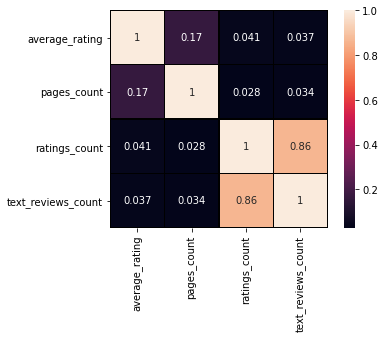

In [12]:
print("The following heatmap displays the correlation between the features:")

sns.heatmap(data=books_data.corr(),
            linewidths=0.25, square=True,
            linecolor="black", annot=True)

We see a high correlation between the ratings_count and the text_reviews_count (~ 86%). From this 
we can conclude that when a person writes a review he/she will most likely also rate the book itself.

Let's examine the top 10 most rated books.

In [13]:
most_rated = books_data.sort_values(by="ratings_count", ascending = False).head(10)

most_rated_titles = pd.DataFrame(most_rated.title).join(pd.DataFrame(most_rated.ratings_count))
most_rated_titles

,title,ratings_count
2,Harry Potter and the Sorcerer's Stone (Harry P...,5629932
12243,Twilight (Twilight #1),4367341
2000,The Hobbit or There and Back Again,2364968
1717,The Catcher in the Rye,2318478
340,Angels & Demons (Robert Langdon #1),2279854
4,Harry Potter and the Prisoner of Azkaban (Harr...,2149872
5300,Harry Potter and the Chamber of Secrets (Harry...,2115562
2505,Animal Farm,2102616
25,The Fellowship of the Ring (The Lord of the Ri...,2009749
1,Harry Potter and the Order of the Phoenix (Har...,1996446


Text(0.5, 0, 'Ratings count(In Millions)')

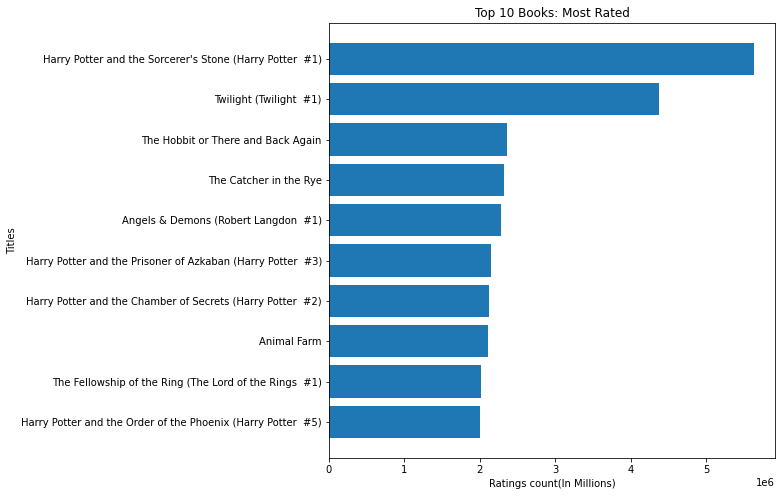

In [51]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.invert_yaxis()

y_axis = most_rated_titles.title
x_axis = most_rated_titles.ratings_count

plt.barh(y_axis,x_axis, align="center")
plt.title('Top 10 Books: Most Rated')
plt.ylabel('Titles')
plt.xlabel('Ratings count(In Millions)')

In [15]:
def scatter_plot(x, y, title, x_label, y_label):
    plt.subplots(figsize=(8, 8))
    plt.scatter(x,
                y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

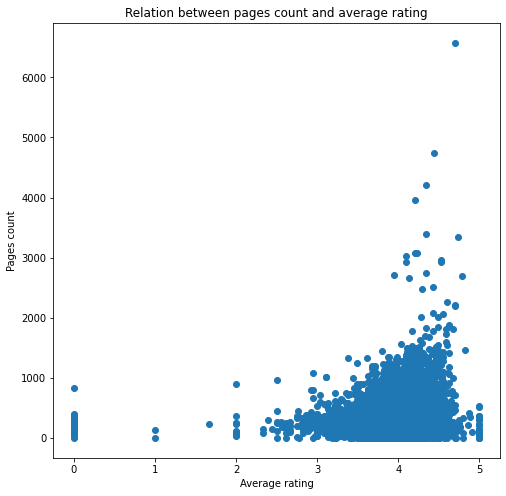

In [16]:
pages_count_and_average_rating_title = "Relation between pages count and average rating"
average_rating_label = "Average rating"
pages_count_label = "Pages count"
scatter_plot(books_data.average_rating,
             books_data.pages_count,
            pages_count_and_average_rating_title, average_rating_label, pages_count_label)

There are a lot of outliers here. We can see that is no significant relation between average rating and the count of pages of a book.

The heatmap also proved this as it displayed a ration of 0.17.
Will drop the ourlier (with pages count >= 2000).

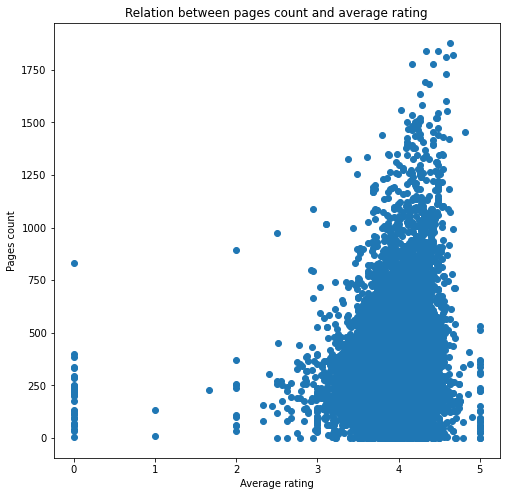

In [17]:
books_data = books_data.drop(books_data.index[books_data["pages_count"] >= 2000])
pages_count_and_average_rating_title = "Relation between pages count and average rating"
average_rating_label = "Average rating"
pages_count_label = "Pages count"
scatter_plot(books_data.average_rating,
             books_data.pages_count,
            pages_count_and_average_rating_title, average_rating_label, pages_count_label)

In [18]:
print("Let`s focus on books ranging between 1-1500 pages.")
limited_by_page_count_books = books_data[books_data.pages_count <= 1500]
limited_by_page_count_books

Let`s focus on books ranging between 1-1500 pages.


,title,authors,average_rating,language_code,pages_count,ratings_count,text_reviews_count
0,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling-Mary GrandPré,4.56,eng,652,1944099,26249
1,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling-Mary GrandPré,4.49,eng,870,1996446,27613
2,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling-Mary GrandPré,4.47,eng,320,5629932,70390
3,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.41,eng,352,6267,272
4,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling-Mary GrandPré,4.55,eng,435,2149872,33964
...,...,...,...,...,...,...,...
13709,M Is for Magic,Neil Gaiman-Teddy Kristiansen,3.82,eng,260,11317,1060
13710,Black Orchid,Neil Gaiman-Dave McKean,3.72,eng,160,8710,361
13711,InterWorld (InterWorld #1),Neil Gaiman-Michael Reaves,3.53,en-US,239,14334,1485
13712,The Faeries' Oracle,Brian Froud-Jessica Macbeth,4.43,eng,224,1550,38


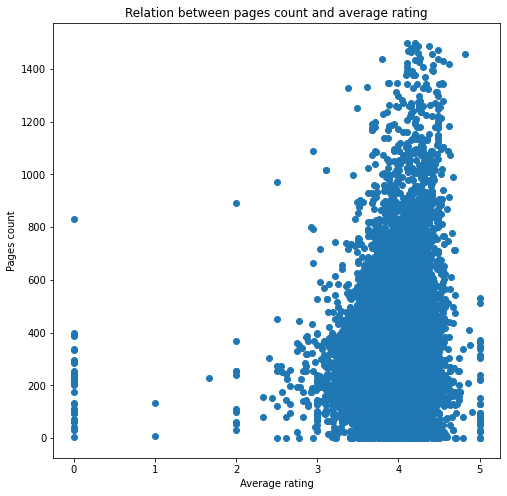

In [19]:
scatter_plot(limited_by_page_count_books.average_rating,
             limited_by_page_count_books.pages_count,
             pages_count_and_average_rating_title,
             average_rating_label,
             pages_count_label)

([], <a list of 0 Text major ticklabel objects>)

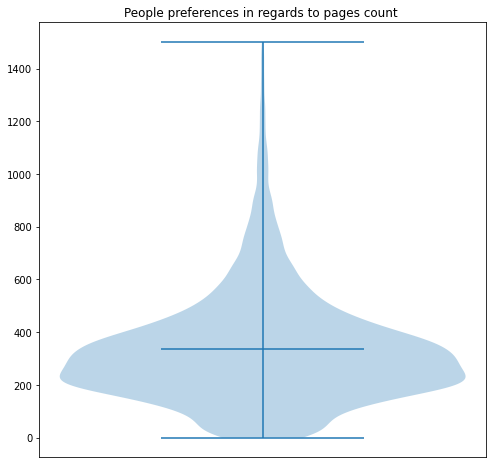

In [20]:
plt.subplots(figsize=(8, 8))
plt.title("People preferences in regards to pages count ")
violionplot = plt.violinplot(limited_by_page_count_books.pages_count, showmeans=True, points=1000, widths=1)
plt.xticks([], None)

We can conclude that people tend to prefer books with pages count between 200 and 400.

In [21]:
books_data[books_data["pages_count"] == 0]

,title,authors,average_rating,language_code,pages_count,ratings_count,text_reviews_count
339,The 5 Love Languages / The 5 Love Languages Jo...,Gary Chapman,4.71,eng,0,20,4
421,The Clan of the Cave Bear Part 1 of 2 (Earth'...,Jean M. Auel-Donada Peters,4.43,eng,0,611,34
959,The Tragedy of Pudd'nhead Wilson,Mark Twain-Michael Prichard,3.79,eng,0,3,0
977,The Lady and the Unicorn,Tracy Chevalier,3.68,eng,0,303,24
1426,The Da Vinci Code (Robert Langdon #2),Dan Brown-Paul Michael,3.82,eng,0,90,16
...,...,...,...,...,...,...,...
12072,Fine Lines (One-Eyed Mack #6),Jim Lehrer,3.23,eng,0,17,3
12594,Stowaway and Milk Run: Two Unabridged Stories ...,Mary Higgins Clark-Jan Maxwell,3.40,eng,0,55,0
12960,The Mask of the Enchantress,Victoria Holt,3.84,eng,0,20,1
13147,Treasury of American Tall Tales: Volume 1: Dav...,David Bromberg-Jay Ungar-Molly Mason-Garrison ...,3.86,eng,0,36,9


There are 0 values in the pages_count column. Will replace them with the mean of the column.

Text(0.5, 1.0, 'Boxplot of count of pages')

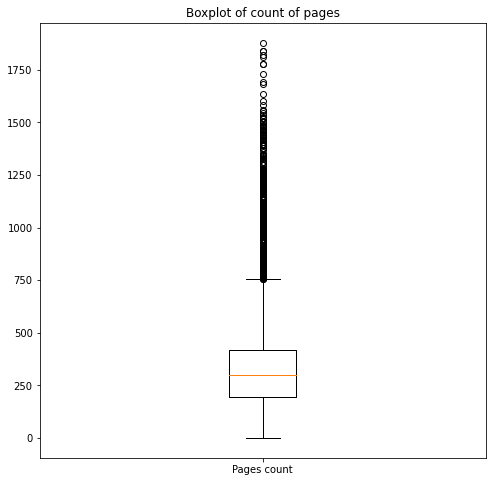

In [22]:
plt.subplots(figsize=(8,8))
plt.boxplot(books_data.pages_count)
plt.xticks([1], ["Pages count"])
plt.title("Boxplot of count of pages")

In [23]:
print("Mean of pages count", float(floor(books_data.pages_count.mean())))

Mean of pages count 337.0


In [24]:
books_data.pages_count = books_data.pages_count.replace(0, np.nan)
books_data.pages_count.fillna(float(floor(books_data.pages_count.mean())), inplace=True)

print("Count of 0s in pages count column:", len(books_data[books_data["pages_count"] == 0]))
print("Are there any NaNs in pages count column:" , books_data.pages_count.isna().any().any())

Count of 0s in pages count column: 0
Are there any NaNs in pages count column: False


In [25]:
books_data

,title,authors,average_rating,language_code,pages_count,ratings_count,text_reviews_count
0,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling-Mary GrandPré,4.56,eng,652.0,1944099,26249
1,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling-Mary GrandPré,4.49,eng,870.0,1996446,27613
2,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling-Mary GrandPré,4.47,eng,320.0,5629932,70390
3,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.41,eng,352.0,6267,272
4,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling-Mary GrandPré,4.55,eng,435.0,2149872,33964
...,...,...,...,...,...,...,...
13709,M Is for Magic,Neil Gaiman-Teddy Kristiansen,3.82,eng,260.0,11317,1060
13710,Black Orchid,Neil Gaiman-Dave McKean,3.72,eng,160.0,8710,361
13711,InterWorld (InterWorld #1),Neil Gaiman-Michael Reaves,3.53,en-US,239.0,14334,1485
13712,The Faeries' Oracle,Brian Froud-Jessica Macbeth,4.43,eng,224.0,1550,38


Text(0.5, 1.0, 'Boxplot of count of ratings')

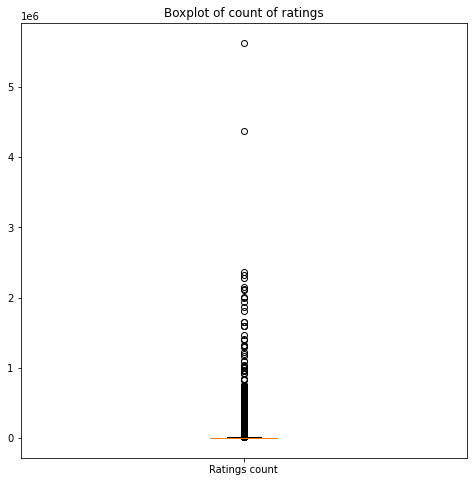

In [26]:
plt.subplots(figsize=(8,8))
plt.boxplot(books_data.ratings_count)
plt.xticks([1], ["Ratings count"])
plt.title("Boxplot of count of ratings")

There are a few  ourliers here. I will leave them as they are the most popular books (i.e Harry Potter and Twilight).

I`m going to encode all the string and categorical variables.

In [27]:
encoder = LabelEncoder()
books_data.title = encoder.fit_transform(books_data.title)
books_data.sample(5)
books_data.authors = encoder.fit_transform(books_data.authors)

In [28]:
books_data = pd.get_dummies(books_data)

In [29]:
books_data.sample(5)

,title,authors,average_rating,pages_count,ratings_count,text_reviews_count,language_code_ale,language_code_ara,language_code_cat,language_code_dan,language_code_en-CA,language_code_en-GB,language_code_en-US,language_code_eng,language_code_enm,language_code_fre,language_code_ger,language_code_gla,language_code_glg,language_code_grc,language_code_heb,language_code_ita,language_code_jpn,language_code_lat,language_code_msa,language_code_mul,language_code_nl,language_code_nor,language_code_por,language_code_rus,language_code_spa,language_code_srp,language_code_swe,language_code_tur,language_code_wel,language_code_zho
9135,7205,5354,3.32,290.0,4053,660,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5810,9081,5949,4.80,339.0,20,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
211,8375,5517,3.83,306.0,17317,1138,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5729,3168,1827,3.82,100.0,10,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4701,7814,4926,3.84,350.0,3740,47,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
books_data.shape

(13689, 36)

Text(0.5, 1.0, 'Boxplot of count of pages')

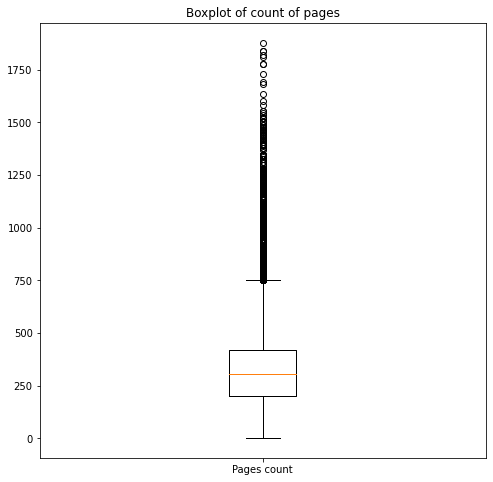

In [31]:
plt.subplots(figsize=(8,8))
plt.boxplot(books_data.pages_count)
plt.xticks([1], ["Pages count"])
plt.title("Boxplot of count of pages")

Now we will focus no the target (i.e the average_rating). A histogram is a good way to visualize the sample.

Text(0.5, 1.0, 'Histogram of the average rating')

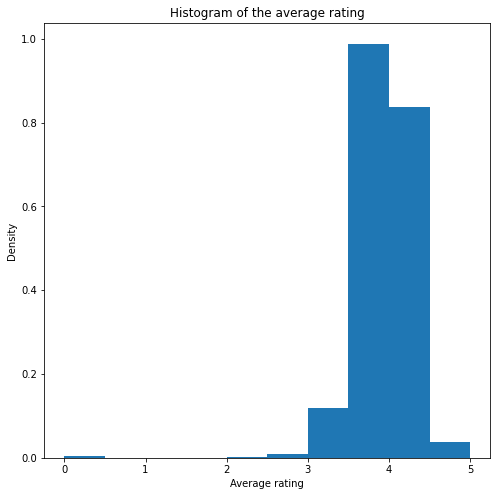

In [32]:
plt.subplots(figsize=(8,8))
plt.hist(books_data.average_rating,density=True)
plt.xlabel("Average rating")
plt.ylabel("Density")
plt.title("Histogram of the average rating")

From the histogram we see that most of ratings vary from 3 to 4.5. We can conclude that people tend to like the books they rate thus most of the ratings are very high.

### Chosing the best model for regression
I'm going to try whether we can use the non-modified for predictions. If the scores are not good I will try to transform the data using a polynom and repeat the same steps and parameter tuning.

In [33]:
book_data=StandardScaler().fit_transform(books_data)
books_data_attributes =books_data.drop("average_rating", axis =1)
books_data_labels =books_data.average_rating

X_train, X_test, y_train, y_test = train_test_split (books_data_attributes, books_data_labels, test_size = 0.3)

In [34]:
k_fold = list(KFold(n_splits=5, shuffle=True).split(X_train, y_train))

In [35]:
def grid_search_best_model(model, params, k_fold, X_train, y_train):
    grid_search = GridSearchCV(model,
                           params,                             
                          cv=k_fold).fit(X_train,y_train)
    print("Best params", grid_search.best_params_)
    print("Best estimator", grid_search.best_estimator_)
    print("Best score:", grid_search.best_score_)
    
    return grid_search.best_estimator_

In [36]:
model_results = {}

def score_model(model,X_train, X_test, y_train, y_test,
               show_plot=True):   
    y_pred = model.predict(X_test)  
    print(f"Training score: {model.score(X_train,y_train)}")
    print(f"Test score: {r2_score(y_test, y_pred)}")
    print("MSE: ", mean_squared_error(y_test, y_pred))
    
    predictions_comparision = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).sample(25)
    if show_plot == True:
        predictions_comparision.plot(kind="bar", figsize=(12,8),title="Actual vs predicted values")
    print(predictions_comparision.sample(10))    
    
    
    return {
        "training_score": model.score(X_train,y_train),
        "test_score_r2" : r2_score(y_test, y_pred),
        "test_score_mse" : mean_squared_error(y_test, y_pred)
    }

def compare_results():
    for key in model_results:
        print("Regression: ", key)
        print("Trainign score", model_results[key]["training_score"])
        print("R2 Test score ", model_results[key]["test_score_r2"])
        print("MSE Test score ", model_results[key]["test_score_mse"])
        print()

Best params {'fit_intercept': True}
Best estimator LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Best score: 0.026219339502260585
Training score: 0.054651570918810344
Test score: 0.0191137084787103
MSE:  0.11247859277953683
      Actual  Predicted
1777    4.00   4.010695
2065    4.01   3.942140
3148    4.04   3.882693
1416    3.96   3.892425
1402    3.31   3.896429
2859    3.59   3.859084
2857    4.24   3.865951
3143    4.18   3.987841
1186    4.27   4.255050
597     4.02   3.906516


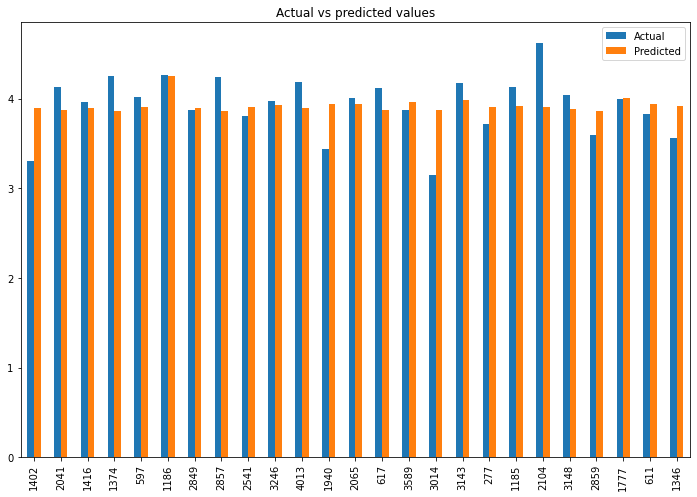

In [37]:
params={
    "fit_intercept":[True,False],
}

linear_regression = grid_search_best_model(LinearRegression(), params, k_fold, X_train, y_train)
model_results["linear_regression"] = score_model(linear_regression, X_train, X_test, y_train, y_test)

Best params {'leaf_size': 20, 'n_neighbors': 29}
Best estimator KNeighborsRegressor(algorithm='auto', leaf_size=20, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=29, p=2,
                    weights='uniform')
Best score: -0.0038441649275008593
Training score: 0.06755886981501014
Test score: 0.002626160392752097
MSE:  0.11436922599882397
      Actual  Predicted
844     4.01   4.071034
3102    4.22   3.867931
3227    4.02   3.881034
1577    3.85   3.948621
1977    3.57   3.927586
2761    3.85   3.947931
496     4.13   3.858621
1623    3.78   3.898621
1320    3.76   3.825862
1475    4.30   4.021034


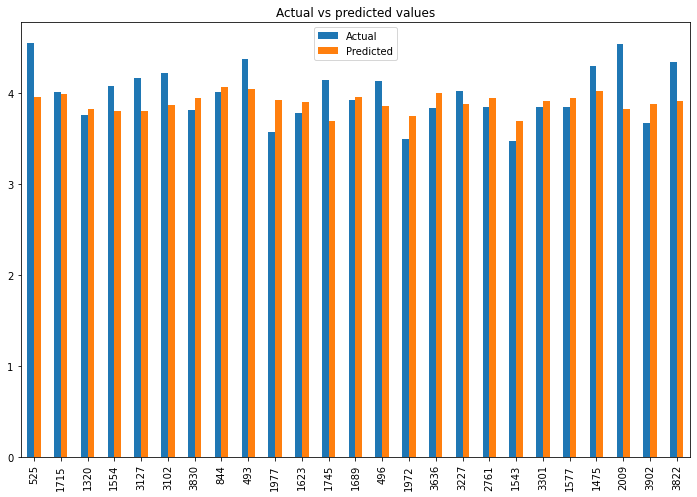

In [38]:
params={
    "n_neighbors": range(2, 30),
    "leaf_size":[20,30,50,70]
}

knn = grid_search_best_model(KNeighborsRegressor(), params, k_fold, X_train, y_train)
model_results["knn"] = score_model(knn, X_train, X_test, y_train, y_test)

Best params {'max_depth': 50, 'max_leaf_nodes': 20, 'min_samples_leaf': 20, 'min_samples_split': 40}
Best estimator DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=50,
                      max_features=None, max_leaf_nodes=20,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=20, min_samples_split=40,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
Best score: 0.1527276063121906
Training score: 0.2238261658403088
Test score: 0.06081093588778619
MSE:  0.10769715633545397
      Actual  Predicted
2684    4.26   4.040775
3689    3.74   3.891364
3058    3.57   1.484400
4070    3.94   3.961019
487     3.50   3.894562
2030    3.93   3.894562
278     3.40   3.848845
501     3.89   3.894562
3212    3.65   4.040775
1833    4.11   3.848845


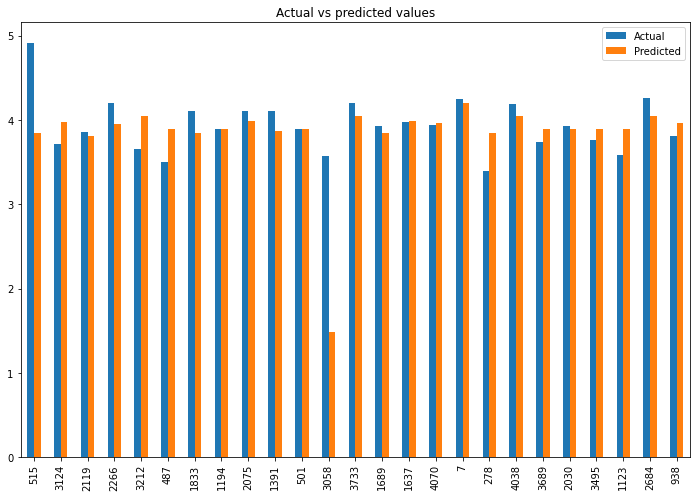

In [39]:
params = {    "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8, 15, 50],
              "min_samples_leaf": [5, 20, 30],
              "max_leaf_nodes": [5, 20],
              }
dtr = grid_search_best_model(DecisionTreeRegressor(), params, k_fold, X_train, y_train)
model_results["dtr"] = score_model(dtr, X_train, X_test, y_train, y_test)

Best params {'learning_rate': 1, 'n_estimators': 1000}
Best estimator AdaBoostRegressor(base_estimator=None, learning_rate=1, loss='linear',
                  n_estimators=1000, random_state=None)
Best score: 0.11675742964822448
Training score: 0.23344257437711746
Test score: 0.01832877116059284
MSE:  0.11256860183127418
      Actual  Predicted
907     4.04   3.917230
2181    3.88   3.910247
2098    3.86   3.874567
59      4.03   3.915021
2533    4.35   3.874567
1614    3.49   3.875060
628     3.82   3.998397
2424    4.16   4.020968
2918    3.64   3.917230
3400    3.21   3.874567


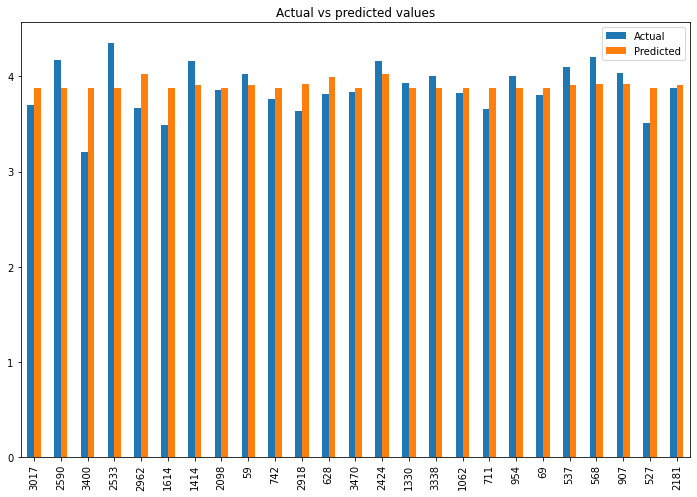

In [40]:
params = {"learning_rate":[0.3, 0.5,1],
          "n_estimators": [50, 100,200,400,700,1000]
              }
abr = grid_search_best_model(AdaBoostRegressor(), params, k_fold, X_train, y_train)
model_results["abr"] = score_model(abr, X_train, X_test, y_train, y_test)

The data is normalized using the standar scaler. Will try to use relatively small C.

Best params {'C': 0.1, 'fit_intercept': True}
Best estimator LinearSVR(C=0.1, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)
Best score: -447.35492663990834
Training score: -52.46650719212725
Test score: -40.487973429633215
MSE:  4.757441213091593
      Actual  Predicted
1680    3.94   3.075523
2358    4.13   4.296769
3642    3.99   7.166097
3544    4.06   4.320165
912     3.74   5.215212
3139    3.91   4.942050
26      3.69   8.028200
1371    3.56   3.424698
3059    4.14   4.462631
3882    4.22   3.645142


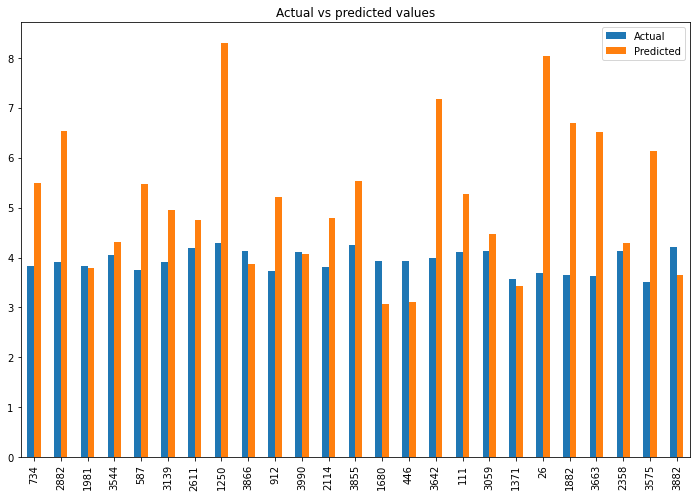

In [41]:
params = {
  "C": [0.1,1, 5, 10, 150,500,1000,5000],
    "fit_intercept":[True,False]
}
linear_svr = grid_search_best_model(LinearSVR(), params,k_fold, X_train, y_train)
model_results["linear_svr"] = score_model(linear_svr, X_train, X_test, y_train, y_test)

Best params {'learning_rate': 0.05, 'max_depth': 10, 'max_features': 0.3, 'min_samples_leaf': 5, 'n_estimators': 100}
Best estimator GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls',
                          max_depth=10, max_features=0.3, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
Best score: 0.20476690476392934
Training score: 0.5486441662586472
Test score: 0.12250123343038732
MSE:  0.10062310716612465
      Actual  Predicted
278     3.40   3.785467
3727    4.15   4.001967
189

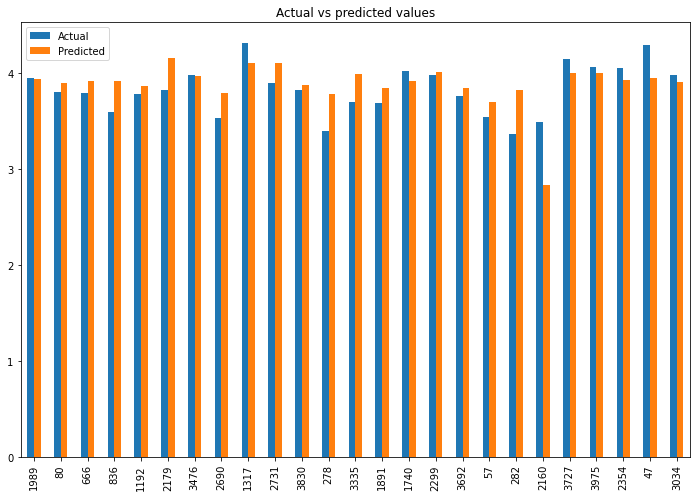

In [42]:
params={"n_estimators":[20, 50, 100,200], 
        "learning_rate": [0.01, 0.05, 0.1, 0.3],
         "max_depth":[3,5,10], 
        "min_samples_leaf": [3,5],
          "max_features": [0.3, 1]
       }        

gbr = grid_search_best_model(GradientBoostingRegressor(), params,k_fold, X_train, y_train)
model_results["gbr"] = score_model(gbr, X_train, X_test, y_train, y_test)

Best params {'C': 1, 'epsilon': 0.01, 'gamma': 0.001}
Best estimator SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma=0.001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Best score: 0.016041824102885082
Training score: 0.8025762519618768
Test score: 0.024288337199910193
MSE:  0.11188521619577968
      Actual  Predicted
3154    4.05   3.934626
2588    3.79   3.936716
1215    3.86   3.934626
2628    4.21   3.934734
2845    4.12   3.934626
3996    3.90   3.934626
1084    3.81   3.934626
584     4.45   3.934626
3782    3.66   3.934626
1089    4.02   3.934626


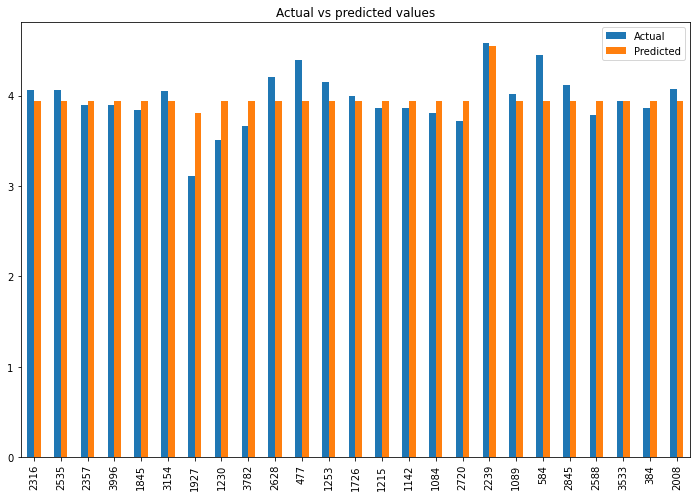

In [43]:
params = { 
    "C": [1, 5, 50, 100],
    "gamma": [0.001, 0.01, 0.1],
    "epsilon" : [0.01, 0.1]
}

gaussian_svr = grid_search_best_model(SVR(), params, k_fold,X_train, y_train)
model_results["gaussian_svr"] = score_model(gaussian_svr, X_train, X_test, y_train, y_test)

From what we can see the score of all algorithms are not very good. Plus some overfit. I will try
to transform the data with polynom of 2nd degree in order to improve the scores.

In [44]:
quad_transformer= PolynomialFeatures(degree=2, interaction_only=True)
books_data_attributes_quad_transformed = quad_transformer.fit_transform(books_data_attributes)
X_train_quad_transformed, X_test_quad_transformed, y_train_quad_transformed, y_test_quad_transformed = train_test_split (books_data_attributes_quad_transformed, books_data_labels, test_size = 0.3)
k_fold_quad_transformed = list(KFold(n_splits=5, shuffle=True).split(X_train_quad_transformed, y_train_quad_transformed))

Best params {'fit_intercept': False}
Best estimator LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)
Best score: -83.07828492335062
Training score: 0.06345787520499557
Test score: -114.73281667559692
MSE:  15.345999246200146
      Actual  Predicted
2683    4.18   3.940331
1094    3.70   3.867943
3458    3.32   3.929091
2623    4.20   3.926359
30      3.88   3.866382
1824    4.22   3.828309
694     3.99   3.974701
932     4.28   3.879157
2358    4.18   3.852053
1608    3.31   3.915587


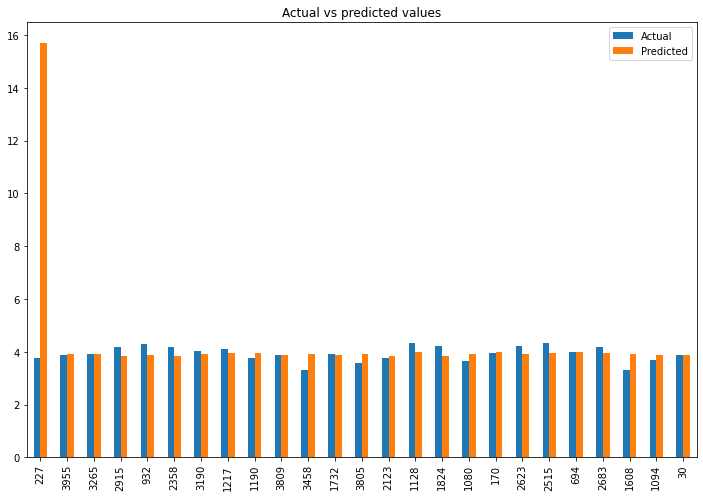

In [45]:
params={
    "fit_intercept":[True,False],
}

linear_regression_quad_transformed = grid_search_best_model(LinearRegression(), params, k_fold_quad_transformed,X_train_quad_transformed, y_train_quad_transformed)
model_results["linear_regression_quad_transformed"] = score_model(linear_regression_quad_transformed, X_train_quad_transformed, X_test_quad_transformed, y_train_quad_transformed, y_test_quad_transformed)

Best params {'learning_rate': 0.5, 'n_estimators': 400}
Best estimator AdaBoostRegressor(base_estimator=None, learning_rate=0.5, loss='linear',
                  n_estimators=400, random_state=None)
Best score: 0.11987490600563426
Training score: 0.21927182034470874
Test score: 0.11038612418830973
MSE:  0.11796147592158285
      Actual  Predicted
3564    3.97   3.897465
292     4.38   3.697470
1018    3.54   3.897465
880     4.05   3.897465
706     3.98   3.897465
764     3.57   3.897465
1908    4.02   3.897465
3892    4.33   2.453408
2941    4.32   3.909103
605     3.63   3.897465


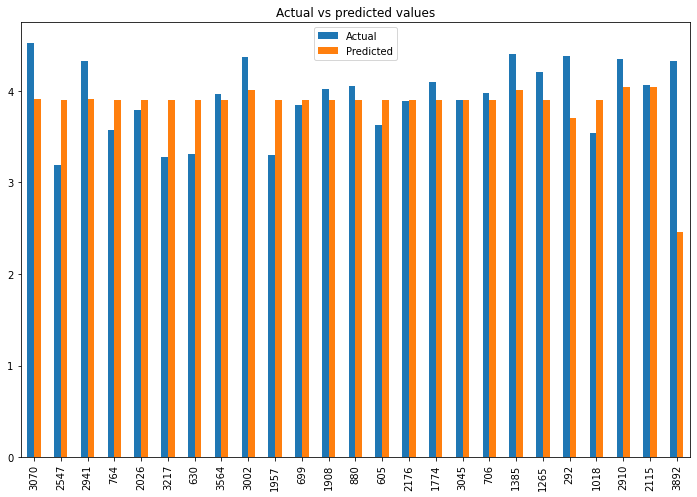

In [46]:
params = {"learning_rate":[0.3, 0.5,1],
          "n_estimators": [50, 100,200,400]}
              
abr_quad_transformed = grid_search_best_model(AdaBoostRegressor(), params,k_fold_quad_transformed,  X_train_quad_transformed, y_train_quad_transformed)
model_results["abr_quad_transformed"] = score_model(abr_quad_transformed, X_train_quad_transformed, X_test_quad_transformed, y_train_quad_transformed, y_test_quad_transformed)

Best params {'learning_rate': 0.05, 'max_depth': 10, 'max_features': 0.3, 'min_samples_leaf': 5, 'n_estimators': 50}
Best estimator GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls',
                          max_depth=10, max_features=0.3, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=5, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
Best score: 0.19814815215691256
Training score: 0.5325661272951934
Test score: 0.1807616640443559
MSE:  0.1086297840764855
      Actual  Predicted
1087    4.28   4.223946
582     3.68   3.884624
1462   

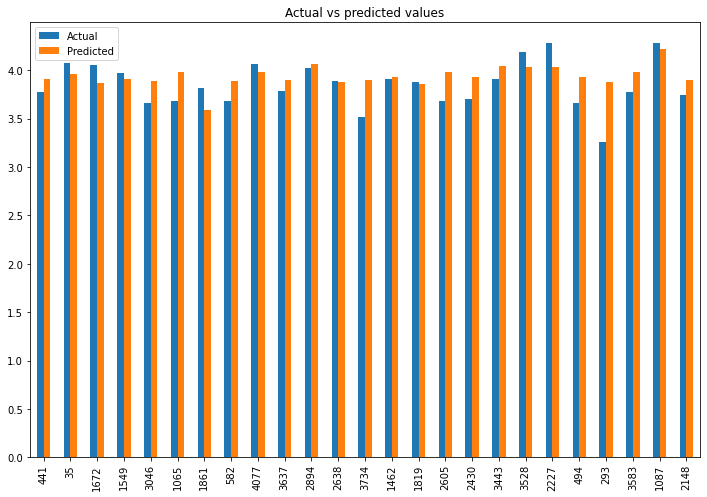

In [47]:
params={"n_estimators":[20, 50, 100,200,400], 
        "learning_rate": [0.01, 0.05, 0.1, 0.3],
         "max_depth":[3,5,10], 
        "min_samples_leaf": [3,5],
        "max_features": [0.3, 1]
       }        

gbr_quad_transformed = grid_search_best_model(GradientBoostingRegressor(), params,k_fold_quad_transformed,  X_train_quad_transformed, y_train_quad_transformed)
model_results["gbr_quad_transformed"] = score_model(gbr_quad_transformed,  X_train_quad_transformed,
                                                    X_test_quad_transformed, y_train_quad_transformed, y_test_quad_transformed)

### Comparing the results

In [48]:
compare_results()

Regression:  linear_regression
Trainign score 0.054651570918810344
R2 Test score  0.0191137084787103
MSE Test score  0.11247859277953683

Regression:  knn
Trainign score 0.06755886981501014
R2 Test score  0.002626160392752097
MSE Test score  0.11436922599882397

Regression:  dtr
Trainign score 0.2238261658403088
R2 Test score  0.06081093588778619
MSE Test score  0.10769715633545397

Regression:  abr
Trainign score 0.23344257437711746
R2 Test score  0.01832877116059284
MSE Test score  0.11256860183127418

Regression:  linear_svr
Trainign score -52.46650719212725
R2 Test score  -40.487973429633215
MSE Test score  4.757441213091593

Regression:  gbr
Trainign score 0.5486441662586472
R2 Test score  0.12250123343038732
MSE Test score  0.10062310716612465

Regression:  gaussian_svr
Trainign score 0.8025762519618768
R2 Test score  0.024288337199910193
MSE Test score  0.11188521619577968

Regression:  linear_regression_quad_transformed
Trainign score 0.06345787520499557
R2 Test score  -114.732

From the observations we see that a GradientBoostingRegressor with preprocessed data (using polynoms of 2nd degree) performed the best on the test data with score like ~19%. On the training data it did good - around 53%. However the overall scores are not very good but the actual vs. predicted data printed displays some satisfying results.

### Serializing the best model

In [49]:
model_dump_filename = "books_model.pkl"
pickle.dump(gbr_quad_transformed, open(model_dump_filename, "wb"))
print("Successfully dumped the model to", model_dump_filename)

Successfully dumped the model to books_model.pkl
